In [107]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import seaborn as sns

# Introduction 

Twitter, or X, is a widely used form of communication and depending on the person, these tweets are programmatically monitored. We'd like to build an ML model that predicts which tweets are about real disasters and which ones are fake. 

This dataset has 10,000 tweets that were classified by humans and it comes with 5 columns of data.

# Exploratory Data Analysis (EDA)

In [108]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [109]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [110]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [111]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [112]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [113]:
exp = train.explode('text')
ord_list = exp['text'].value_counts().index

In [114]:
words = train['text'].str.split(expand=True)
print(words)

                0              1         2           3           4         5   \
0              Our          Deeds       are         the      Reason        of   
1           Forest           fire      near          La       Ronge     Sask.   
2              All      residents     asked          to    'shelter        in   
3           13,000         people   receive  #wildfires  evacuation    orders   
4             Just            got      sent        this       photo      from   
...            ...            ...       ...         ...         ...       ...   
7608           Two          giant    cranes     holding           a    bridge   
7609  @aria_ahrary   @TheTawniest       The         out          of   control   
7610         M1.94         [01:04  UTC]?5km           S          of   Volcano   
7611        Police  investigating     after          an      e-bike  collided   
7612           The        Latest:      More       Homes       Razed        by   

            6              

In [115]:
wc = words.unstack().value_counts()
top_30 = wc[:30]
print(top_30)

the      2575
a        1845
to       1805
in       1757
of       1722
and      1302
I        1197
for       820
is        814
on        773
-         763
you       632
The       552
my        549
with      508
that      492
at        485
by        469
it        433
from      372
be        371
was       363
have      353
are       345
this      335
like      318
&amp;     295
A         290
as        282
just      258
Name: count, dtype: int64


In [116]:
percentages = top_30 / np.sum(wc) * 100
print(percentages)

the      2.269502
a        1.626109
to       1.590855
in       1.548550
of       1.517702
and      1.147531
I        1.054988
for      0.722715
is       0.717427
on       0.681291
-        0.672478
you      0.557020
The      0.486511
my       0.483867
with     0.447731
that     0.433629
at       0.427460
by       0.413358
it       0.381629
from     0.327866
be       0.326985
was      0.319934
have     0.311120
are      0.304069
this     0.295256
like     0.280273
&amp;    0.260001
A        0.255594
as       0.248544
just     0.227391
Name: count, dtype: float64


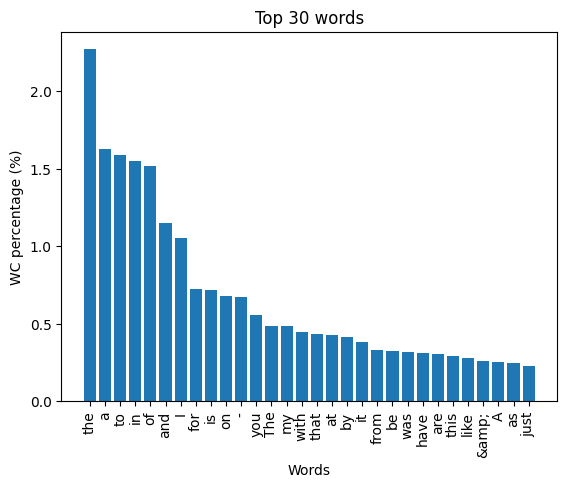

In [117]:
plt.bar(percentages.index, percentages.values)
plt.xlabel('Words')
plt.ylabel('WC percentage (%)')
plt.title('Top 30 words')
# Rotating X-axis labels
plt.xticks(rotation = 90)
plt.show()

From this count plot above, we can see in the top 30 words that they are mostly all prepositions and therefore the data needs to be cleaned in order for us to see useful twitter keywords that aren't stop words like "the" or "a" for example.

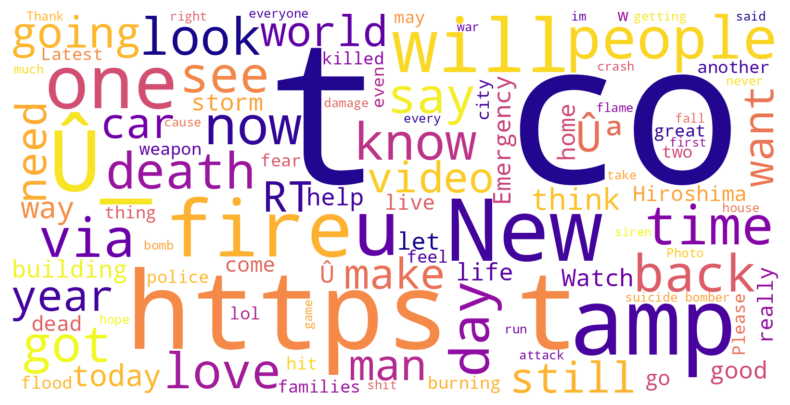

In [118]:
from wordcloud import WordCloud
text_title = ' '.join(train['text'])
wordcloud = WordCloud(background_color='white', width=800, height=400, max_words=100, scale=2.0, colormap='plasma').generate(text_title)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Upon analysis, we can see that word prepositions form the majority of the top 30 word frequency. We can discard these values because they aren't going to provide much value in terms of using word values and frequencies to determine category. 

### Clean text data
I want to remove stop words and prepositions via data cleaning because we know words like "the" or "that" are not meaningful in building a model with word analysis.

In [119]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import re
import spacy

nltk.download('stopwords')
nltk.download('punkt')

!spacy download en
# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [120]:
stopWords = set(stopwords.words('english'))
print(stopWords)

{'himself', 'yours', 'isn', 'myself', "you've", 'while', 'should', 've', 'now', "couldn't", 'we', 'wouldn', 'because', 'there', 'same', 'ma', "didn't", 'don', 'me', 'not', 'against', 'has', 'other', 'needn', 'hadn', 'that', 'was', 'being', "isn't", 'further', 'once', 'any', 'ain', "hadn't", 'no', 'an', 'd', 'aren', 'until', 'out', 'few', 'weren', 're', 'your', 'of', 'they', 'most', 'hasn', 'doing', 'during', 'under', 'why', 'she', 'own', 'her', 'their', 'before', 'who', 'through', 'doesn', 'shouldn', 'itself', 'just', 'below', 'i', "you'd", 'when', 'then', 'each', 'its', 'herself', 'did', 'on', "you're", 'theirs', 'haven', 'it', 'hers', 'am', 'is', "shan't", "needn't", 'wasn', "you'll", 's', "won't", 'if', 'again', 'into', 'all', 'but', "aren't", 'those', 'had', 'too', 'or', 'y', "mightn't", "should've", "don't", 'so', 'above', "hasn't", 'can', 'themselves', 'very', 'our', 'shan', 'where', 'been', 'down', 'mightn', 'nor', 'up', 'didn', 'yourselves', 'by', 'such', "wouldn't", 't', 'be',

In [121]:
def clean_words(words):
    words = words.lower()
    words = re.sub(r'\b([a-zA-Z])\b|\d+|[.,!?()-\:]', '', words)
    wordsFiltered = word_tokenize(words)
    wordsFiltered = [w for w in wordsFiltered if w not in stopWords]
    words = nlp(words)
    wordsFiltered = [t.lemma_ for t in words]
    return ' '.join(wordsFiltered)

In [122]:
vclean = np.vectorize(clean_words)
train_clean = vclean(train['text'])
test_clean = vclean(test['text'])
print(train_clean[0])

our deed be the reason of this # earthquake may allah forgive we all


In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(stop_words='english').fit(train_clean)

In [124]:
X = tf_idf.transform(train['text']).toarray() #(train_clean)
# X_test = tf_idf.transform(test_clean)
# y_train, y_test = train['target'], test['target']

In [125]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical 

In [126]:
encoder = LabelEncoder()
y = encoder.fit_transform(train['target'])
y_categ = to_categorical(y)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


## Model Building and Training

In [127]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y_categ, test_size=0.2, random_state=42)


In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_categ.shape[1], activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               2418560   
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2426946 (9.26 MB)
Trainable params: 2426946 (9.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [129]:
# Initial model
# X_train = tf.sparse.reorder(X_train)
# y_train = tf.sparse.reorder(y_train)
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/3
191/191 [==============================] - 3s 7ms/step - loss: 0.6043 - accuracy: 0.6685 - val_loss: 0.4819 - val_accuracy: 0.7886
Epoch 2/3
191/191 [==============================] - 1s 4ms/step - loss: 0.3727 - accuracy: 0.8456 - val_loss: 0.4806 - val_accuracy: 0.7840
Epoch 3/3
191/191 [==============================] - 1s 4ms/step - loss: 0.2461 - accuracy: 0.9071 - val_loss: 0.5503 - val_accuracy: 0.7728


In [130]:
from sklearn.metrics import accuracy_score, classification_report
y_preds = model.predict(X_val)
y_preds = np.argmax(y_preds, axis=1)
y_enc = np.argmax(y_val, axis=1)

48/48 [==============================] - 0s 2ms/step


In [131]:
classes = [str(c) for c in encoder.classes_]
print("Classification report below")
print(classification_report(y_enc, y_preds, target_names=classes))

Classification report below
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       874
           1       0.74      0.72      0.73       649

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



# Hyperparameter tuning

In [132]:
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

class TwitterHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                        input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                            activation=hp.Choice('activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])))
            model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(Dense(self.num_classes, activation='softmax'))
        model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

In [133]:
hypermodel = TwitterHyperModel(input_shape=(X_train.shape[1],), num_classes=y_categ.shape[1])

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=2,
    directory='my_dir',
    project_name='hparam_tuning'
)

tuner.search(X_train, y_train,
             epochs=8,
             validation_data=(X_val, y_val),
             verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = hypermodel.build(best_hps)

history = model.fit(X_train, y_train, epochs=8, validation_data=(X_val, y_val))

val_predictions = model.predict(X_val)
val_predictions = np.argmax(val_predictions, axis=1)
y_val_encoded = np.argmax(y_val, axis=1)
print("Accuracy:", accuracy_score(y_val_encoded, val_predictions))
print("Classification Report:\n", classification_report(y_val_encoded, val_predictions))

Epoch 1/8
191/191 [==============================] - 3s 7ms/step - loss: 0.6052 - accuracy: 0.6617 - val_loss: 0.4731 - val_accuracy: 0.7800
Epoch 2/8
191/191 [==============================] - 1s 5ms/step - loss: 0.3730 - accuracy: 0.8453 - val_loss: 0.4709 - val_accuracy: 0.7932
Epoch 3/8
191/191 [==============================] - 1s 5ms/step - loss: 0.2889 - accuracy: 0.8887 - val_loss: 0.5107 - val_accuracy: 0.7846
Epoch 4/8
191/191 [==============================] - 1s 5ms/step - loss: 0.2293 - accuracy: 0.9207 - val_loss: 0.5729 - val_accuracy: 0.7722
Epoch 5/8
191/191 [==============================] - 1s 4ms/step - loss: 0.1817 - accuracy: 0.9406 - val_loss: 0.5728 - val_accuracy: 0.7794
Epoch 6/8
191/191 [==============================] - 1s 5ms/step - loss: 0.1488 - accuracy: 0.9517 - val_loss: 0.6383 - val_accuracy: 0.7597
Epoch 7/8
191/191 [==============================] - 1s 4ms/step - loss: 0.1268 - accuracy: 0.9596 - val_loss: 0.6462 - val_accuracy: 0.7636
Epoch 8/8
48/

# Conclusion

I created a neural network that was trained and then tuned the hyperparameters in order to create a model with a validation accuracy of 0.77. The precision score was pretty satisfactory with a weighted average of 0.77 and the f1 score had a high of 0.81 and an average of 0.77. I think that this neural network performed adequately well for predicting tweet disasters based on the target variable.

In [161]:
X_test = tf_idf.transform(test['text']).toarray()
print(X_test)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [166]:
# X_test = tf.sparse.reorder(X_test)
preds = model.predict(X_test).round()

102/102 [==============================] - 0s 2ms/step


In [167]:
print(preds)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [168]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = np.round(val_predictions).astype('int')

In [169]:
submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,1
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,1


In [170]:
submission.to_csv('submission.csv', index=False)